In [1032]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_score, recall_score

<h4>Получите базовое решение:</h4>

1. Удалите все пропущенные значения
2. Удалите все категориальные переменные
3. Обучите модель
4. Выберете и посчитайте метрику качества

In [1033]:
# Загружаем данные
load = pd.read_csv('weatherAUS.csv', index_col='Date')
data = load.copy()

In [1034]:
data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [1035]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145460 entries, 2008-12-01 to 2017-06-25
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        143975 non-null  float64
 2   MaxTemp        144199 non-null  float64
 3   Rainfall       142199 non-null  float64
 4   Evaporation    82670 non-null   float64
 5   Sunshine       75625 non-null   float64
 6   WindGustDir    135134 non-null  object 
 7   WindGustSpeed  135197 non-null  float64
 8   WindDir9am     134894 non-null  object 
 9   WindDir3pm     141232 non-null  object 
 10  WindSpeed9am   143693 non-null  float64
 11  WindSpeed3pm   142398 non-null  float64
 12  Humidity9am    142806 non-null  float64
 13  Humidity3pm    140953 non-null  float64
 14  Pressure9am    130395 non-null  float64
 15  Pressure3pm    130432 non-null  float64
 16  Cloud9am       89572 non-null   float64
 17  Cloud3pm       86102 

Краткие выводы по данным:
- Данные содержат пропуски (для финальной модели подобрать способ обработки пропусков)
- Часть данных категориальные (для финальной модели подобрать какие данные перекодировать в количественные показатели)
- Много свойств данных 22 (для финальной модели уменьшить размерность, посмотреть на взаимные кореляции)

In [1036]:
# Кодируем целевой признак в количествунный
data['Target'] = 0
data['Target'] = data['Target'].where(data['RainTomorrow'] == 'No', 1) 

In [1037]:
data['Target'].value_counts()

0    110316
1     35144
Name: Target, dtype: int64

In [1038]:
# Исключим категориальные признаки
data.select_dtypes('object')
data.drop(columns = data.select_dtypes('object'), inplace=True)

In [1039]:
data.dropna(inplace=True)

In [1040]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58236 entries, 2009-01-01 to 2017-06-24
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        58236 non-null  float64
 1   MaxTemp        58236 non-null  float64
 2   Rainfall       58236 non-null  float64
 3   Evaporation    58236 non-null  float64
 4   Sunshine       58236 non-null  float64
 5   WindGustSpeed  58236 non-null  float64
 6   WindSpeed9am   58236 non-null  float64
 7   WindSpeed3pm   58236 non-null  float64
 8   Humidity9am    58236 non-null  float64
 9   Humidity3pm    58236 non-null  float64
 10  Pressure9am    58236 non-null  float64
 11  Pressure3pm    58236 non-null  float64
 12  Cloud9am       58236 non-null  float64
 13  Cloud3pm       58236 non-null  float64
 14  Temp9am        58236 non-null  float64
 15  Temp3pm        58236 non-null  float64
 16  Target         58236 non-null  int64  
dtypes: float64(16), int64(1)
memory usage: 8.

In [1041]:
# Делим выборку на обучение и валидацию
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Target'),
                                                    data['Target'],
                                                   random_state=44,
                                                   shuffle=True,
                                                   test_size = 0.2)

In [1042]:
#Масштабируем данные - без этого модель не сойдется

pipe = make_pipeline(StandardScaler(), LogisticRegression())
base_model = pipe.fit(X_train, y_train)

In [1043]:
# accuracy score
base_accuracy = base_model.score(X_test, y_test)
base_accuracy

0.8586023351648352

In [1044]:
# Вероятностные предсказания модели

base_predict = base_model.predict_proba(X_test)[:,1]
base_predict

array([0.21084849, 0.10477563, 0.19090668, ..., 0.69637199, 0.01453486,
       0.28610432])

In [1045]:
# Категориальный предсказания модели

base_round_predict =  base_model.predict(X_test)
base_round_predict

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [1046]:
# Показатель ROC_AUC score нашей модели
base_roc_auc = roc_auc_score(y_test, base_predict)
base_roc_auc

0.8898227896063773

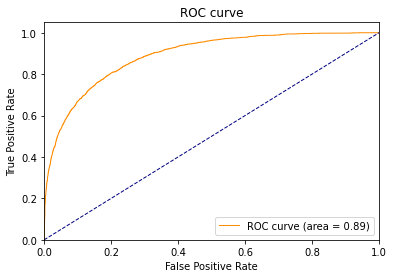

In [1047]:
# ROC кривая модели

fpr, tpr, thresholds = roc_curve(y_test, base_predict)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' %base_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [1048]:
# f1 - score

base_f_score = f1_score(y_test, base_round_predict)
base_f_score

0.6286358511837655

In [1049]:
# Precision

base_precision = precision_score(y_test, base_round_predict)
base_precision

0.7474530831099195

In [1050]:
# Recall

base_recall = recall_score(y_test, base_round_predict)
base_recall

0.5424124513618677

In [1051]:
# Соберем данные базовой модели в фрейм

results = pd.DataFrame({'Описание': "без пропусков, без категорий, MinMax scale",
                        'ROC_AUC': base_roc_auc, 
                        'Accuracy': base_accuracy,
                        'F-score': base_f_score, 
                        'Precision': base_precision, 
                        'Recall': base_recall}, index = ['Базовая модель'])

In [1052]:
results

,Описание,ROC_AUC,Accuracy,F-score,Precision,Recall
Базовая модель,"без пропусков, без категорий, MinMax scale",0.889823,0.858602,0.628636,0.747453,0.542412


<h4>Результаты обучения базовой модели:</h4>

 - Высокий ROC_AUC score говорит о высоком качестве модели
 
 - Модель показывает Accuracy 0.86 при низком F-score и Recall что намекает на дисбаланс классов в тестовых данных
 
Далее поработаем над предобработкой данных, для повышения метрик.

In [1053]:
# Соберем расчет метрик в одну функцию

def score_me_please(y_test, X_test, model):
    
    predict = model.predict_proba(X_test)[:,1]
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, predict)
    f_score = f1_score(y_test, predict.round())
    precision = precision_score(y_test, predict.round())
    recall = recall_score(y_test, predict.round())
    
    
    return [roc_auc, accuracy, f_score, precision, recall]

Далее поработаем с данными и подготовим рабочую модель:

1. Проведите первичный анализ данных
2. Проведите визуальный анализ данных
3. Разбейте данные на обучение и тест
4. Сделайте предобработку данных с помощью класса и пайплайна
5. Обучите модель классификации с целевым признаком RainTomorrow
6. Оцените подходящие метрики качества
7. Сформулируйте выводы по проделанной работе

In [1054]:
#Посмотрим на свойства
data_work = load.copy()
data_work.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145460 entries, 2008-12-01 to 2017-06-25
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        143975 non-null  float64
 2   MaxTemp        144199 non-null  float64
 3   Rainfall       142199 non-null  float64
 4   Evaporation    82670 non-null   float64
 5   Sunshine       75625 non-null   float64
 6   WindGustDir    135134 non-null  object 
 7   WindGustSpeed  135197 non-null  float64
 8   WindDir9am     134894 non-null  object 
 9   WindDir3pm     141232 non-null  object 
 10  WindSpeed9am   143693 non-null  float64
 11  WindSpeed3pm   142398 non-null  float64
 12  Humidity9am    142806 non-null  float64
 13  Humidity3pm    140953 non-null  float64
 14  Pressure9am    130395 non-null  float64
 15  Pressure3pm    130432 non-null  float64
 16  Cloud9am       89572 non-null   float64
 17  Cloud3pm       86102 

In [1055]:
data_work.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


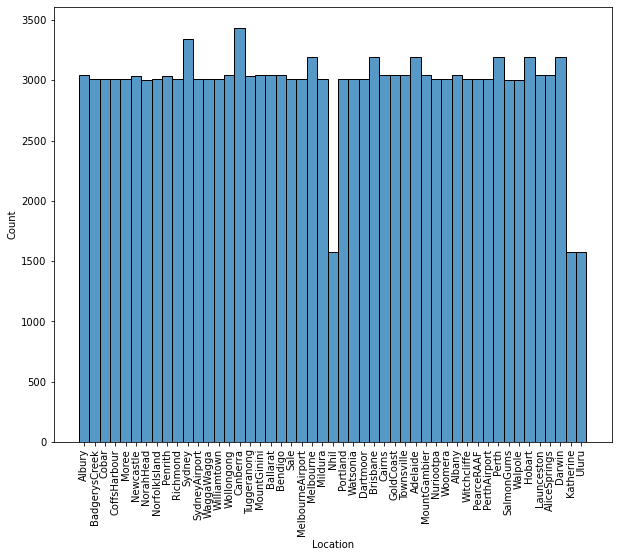

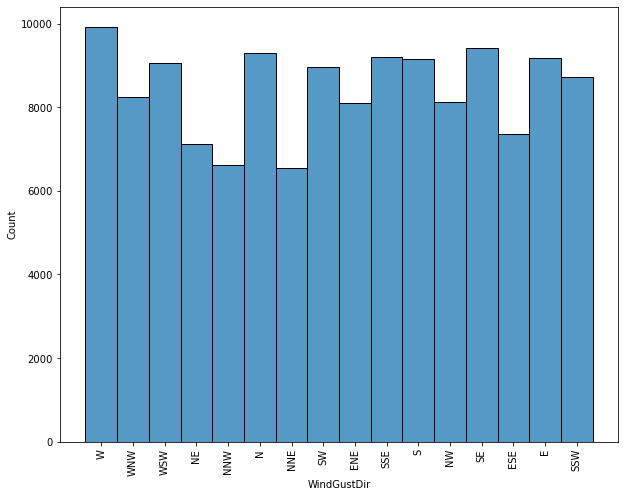

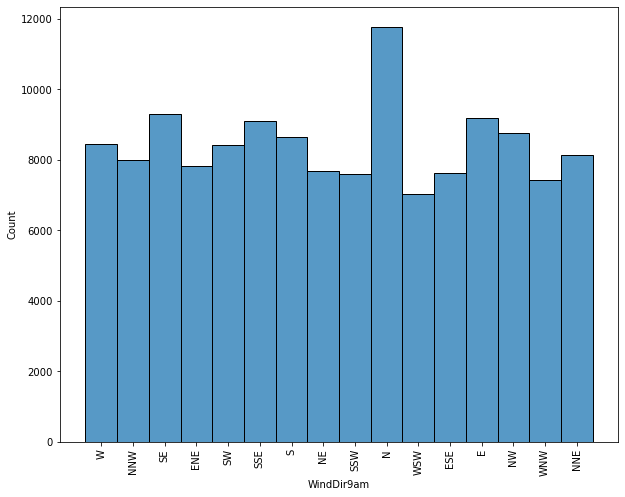

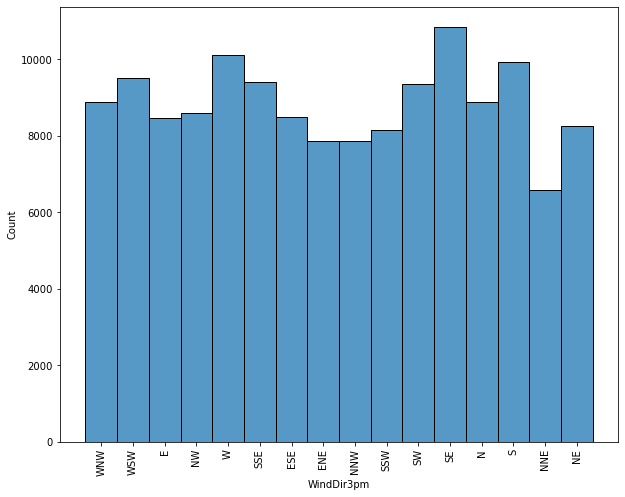

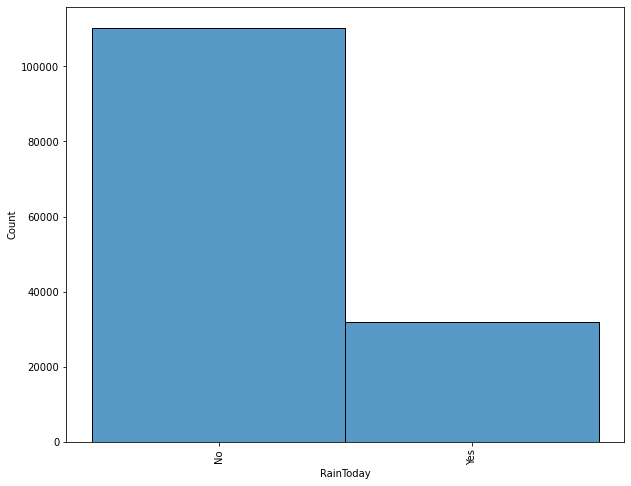

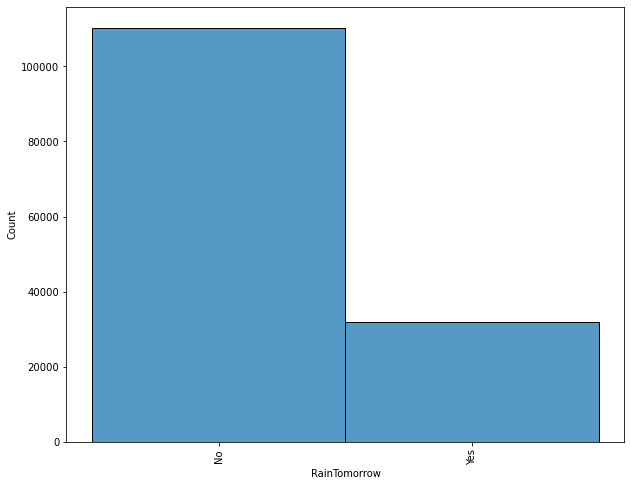

In [1056]:
# Посмоттрим на кодированные категориальные признаки
categorial = data_work.select_dtypes('object')
for col in categorial:
    plt.figure(figsize=(10, 8))
    sns.histplot(data_work[col])
    plt.xticks(rotation='vertical')
    plt.show()

- Целевая харатеристика RainTomorrow, RainToday содержат пропуски - их дропнем
- Целевая характеристика не сбалансирована, проведем оверсемплинг по группе Yes x 2 (1) и андерсемплинг по группе No
- По группе Location также проведем oversampling по значениям меньше медианы

In [1057]:
data_work = data_cop.copy()

# Дропаем пропуски
data_work = data_work.dropna(subset = ["RainTomorrow", "RainToday"])

# Мультиплицируем данные по RainTomorrow = Yes
number = len(data_work.loc[data_work.RainTomorrow == 'Yes', "RainTomorrow"])
data_work = pd.concat((data_work, data_work.loc[data_work.RainTomorrow == 'Yes', :]), ignore_index=True)

# Дропаем то же количество случайных строк где данные по RainTomorrow = No
to_drop = data_work[data_work['RainTomorrow'] == 'No'].sample(n=number).index
data_work = data_work.drop(to_drop)

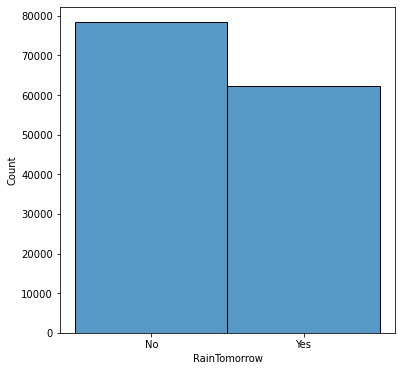

In [1058]:
plt.figure(figsize=(6, 6))
sns.histplot(data_work.RainTomorrow)
plt.show()

In [1059]:
# Выбираем локации с количеством измерений меньше среднего значения
cnt = data_work['Location'].value_counts()
loc_plus = cnt[cnt < cnt.mean()*0.8].index.values
loc_minus = cnt[cnt >= cnt.mean()].index.to_list()
data_work = pd.concat((data_work, data_work.loc[data_work['Location'].isin(loc_plus), :]), ignore_index=True)

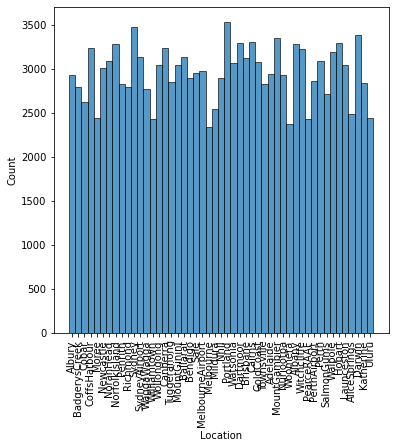

In [1060]:
plt.figure(figsize=(6, 6))
sns.histplot(data_work.Location)
plt.xticks(rotation='vertical')
plt.show()

В количественных данных есть пропуски: Заполним их средними значениями.
И заодно перекодируем

Данных слишком много чтобы рассматривать каждую фичу на графике и искать выбросы. 
Почистим данные от выбросов приняв порог 3 стандартных отклонения

In [1061]:
# Рукописный импутер
class MyImputer():
    def fit(self, data_in, *args, **kwargs):
        self.df = data_in.copy()
        return self
    
    def transform(self, *args, **kwargs):
        numeric = self.df.drop(columns = self.df.select_dtypes('object'))
        self.df.loc[:, numeric.columns] = \
        self.df.loc[:, numeric.columns].apply(lambda x: x.fillna(x.mean()))
        return self.df

In [1062]:
class CutRelese():
    def __init__(self, threshold = 3):
        self.treshold = threshold
        
    def fit(self, data_in, *args, **kwargs):
        self.df = data_in
        return self
    
    def transform(self, *args, **kwargs):
        for col in self.df.select_dtypes(float).columns:
            mean_val = self.df[col].mean()
            std_val = self.df[col].std()
            self.df.loc[:, col] =  self.df.loc[:, col]\
        .apply(lambda x: np.nan if (x >= mean_val + std_val * self.treshold) or\
               ((x < mean_val - std_val * self.treshold)) else x)        
        self.df = self.df.dropna()
        
        return self.df
    
    def counter(data):
        value

In [1063]:
pipe = make_pipeline(MyImputer(), CutRelese())
pipe.fit(data_work)
data_work = pipe.transform(data_work)

In [1064]:
# Кодируем качествынне данные в количественные
label_encoder = LabelEncoder()
for col in data_work.select_dtypes('object'):
    data_work.loc[:, col] = label_encoder.fit_transform(data_work.loc[:, col])
data_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119348 entries, 0 to 144877
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       119348 non-null  int32  
 1   MinTemp        119348 non-null  float64
 2   MaxTemp        119348 non-null  float64
 3   Rainfall       119348 non-null  float64
 4   Evaporation    119348 non-null  float64
 5   Sunshine       119348 non-null  float64
 6   WindGustDir    119348 non-null  int32  
 7   WindGustSpeed  119348 non-null  float64
 8   WindDir9am     119348 non-null  int32  
 9   WindDir3pm     119348 non-null  int32  
 10  WindSpeed9am   119348 non-null  float64
 11  WindSpeed3pm   119348 non-null  float64
 12  Humidity9am    119348 non-null  float64
 13  Humidity3pm    119348 non-null  float64
 14  Pressure9am    119348 non-null  float64
 15  Pressure3pm    119348 non-null  float64
 16  Cloud9am       119348 non-null  float64
 17  Cloud3pm       119348 non-nul

C:\Users\Михаил\AppData\Local\Temp\ipykernel_3716\156188962.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work.loc[:, col] = label_encoder.fit_transform(data_work.loc[:, col])


<h5>Масштабируем данные и обучим новую модель на данном этапе.
    Результаты занесем в таблицу результатов:</h5>

In [1065]:
# Делим выборку на обучение и валидацию
X_train, X_test, y_train, y_test = train_test_split(data_work.drop(columns='RainTomorrow'),
                                                    data_work['RainTomorrow'],
                                                   random_state=44,
                                                   shuffle=True,
                                                   test_size = 0.2)

In [1066]:
# Масштабируем и обучаем новую модель
pipe = make_pipeline(StandardScaler(), LogisticRegression())
step1_model = pipe.fit(X_train, y_train)

In [1067]:
# Посчитаем метрики модели
score_step1 = score_me_please(y_test, X_test, step1_model)
info = '''Пропуски mean, категории Labelencoding, выбросы подрезаны 3 std, свойства перебалансированы '''
results.loc['Шаг 1'] = info, *score_step1

In [1068]:
results

,Описание,ROC_AUC,Accuracy,F-score,Precision,Recall
Базовая модель,"без пропусков, без категорий, MinMax scale",0.889823,0.858602,0.628636,0.747453,0.542412
Шаг 1,"Пропуски mean, категории Labelencoding, выброс...",0.866978,0.787599,0.741932,0.773345,0.712972


<h5>Шаг 2 рассмотрим взаимные корреляции свойств</h5>

 - Ищем свойства которые оказывают наименьшее воздействие на целевой признак
 
 - Ищем свойства которые имеют сильную корреляцию на изменяемый признак

In [1069]:
correlations = abs(data_work.corr())

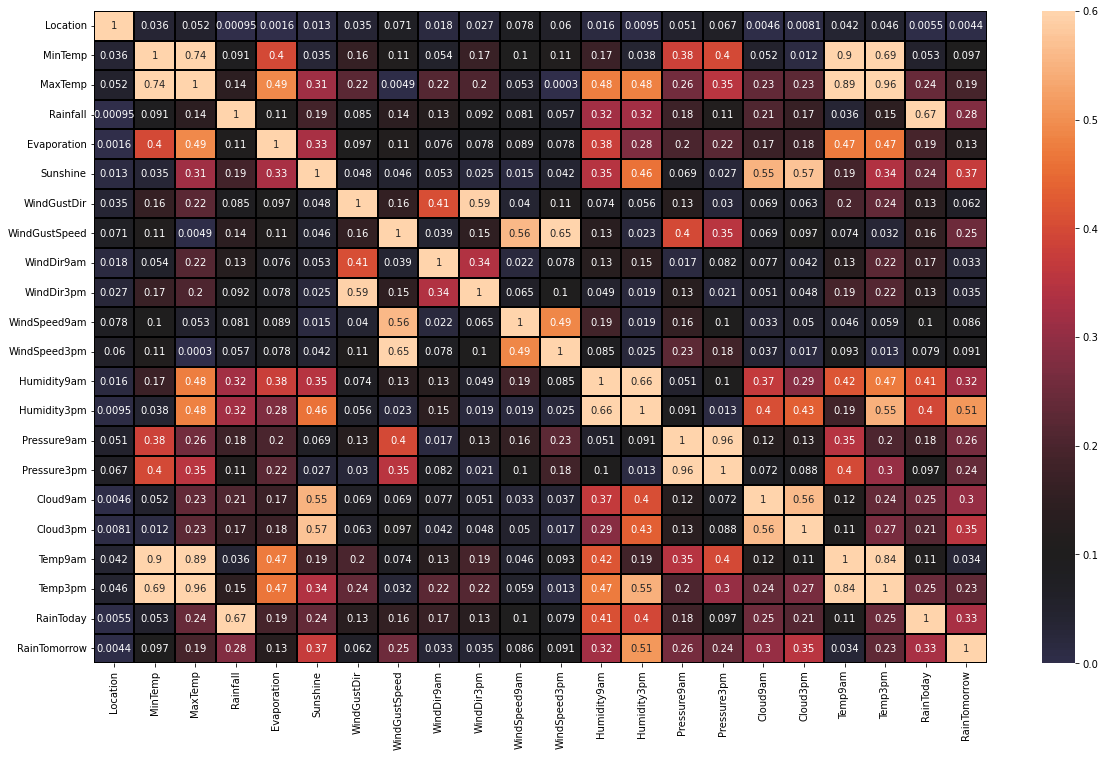

In [1070]:
# Посмотрим тепловую карту корреляций

plt.figure(figsize=(20, 12))
sns.heatmap(correlations, 
            center=0.1, annot=True, 
            linecolor='black', 
            linewidths=0.4, vmin=0, vmax=0.6)
plt.show()

In [1071]:
# Ищем свойства с вкладом менее 5%
correlations[correlations['RainTomorrow'] <= 0.05]['RainTomorrow']

Location      0.004355
WindDir9am    0.033214
WindDir3pm    0.035458
Temp9am       0.033843
Name: RainTomorrow, dtype: float64

 22 свойства - слишком много, упростим модель. Часть данных дропнем, часть объединим.
 
 Наметим план обработки:
 
 В несколько итераций убираем те свойства, которые сильно коррелируют друг с другом, но слабо с целевым таргетом:


In [1072]:
# Напишем костомный класс-обработчик для работы в пайплайне

class StepOne():
    # Вариант 1, объеднияем схожие свойства в 1 ячейку как разность.
    # Дропаем схожие характеристики
    
    def transform(self, *args):
        df_out = self.df.copy()
        
        # Оставляем RainToday
        df_out.drop(columns=['Rainfall'], inplace=True)
        
        # Дропаем оба MinTemp, MaxTemp
        df_out.drop(columns=['MinTemp', 'MaxTemp'], inplace=True)
        
        # Дропаем оба
        df_out.drop(columns=['WindSpeed9am', 'WindSpeed3pm'], inplace=True)
        
        # Оставляем Humidity3pm
        df_out.drop(columns=['Humidity9am'], inplace=True)
        
        # Оставляем Pressure3pm
        df_out.drop(columns=['Pressure9am'], inplace=True)
        
        
        # Обе температуры дропаем
        df_out.drop(columns=['Temp9am', 'Temp3pm'], inplace=True)
        
        # Оставляем 1 облачность
        df_out.drop(columns=['Cloud9am'], inplace=True)
        
        # Sunshine дропнем
        df_out.drop(columns=['Sunshine'], inplace=True)
        
        
        # Дропаем относительные показатели по геоданным
        df_out.drop(columns=['Location', "WindGustDir", "WindDir9am", "WindDir3pm"], inplace=True)

        return df_out
        
    def fit(self, data_in, *args, **kwargs):
        self.df = data_in.copy()
        return self

In [1073]:
# Смотрим на итог обработки первого шага
pipe = make_pipeline(StepOne())
pipe.fit(data_work)
data_work = pipe.transform(data_work)
data_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119348 entries, 0 to 144877
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Evaporation    119348 non-null  float64
 1   WindGustSpeed  119348 non-null  float64
 2   Humidity3pm    119348 non-null  float64
 3   Pressure3pm    119348 non-null  float64
 4   Cloud3pm       119348 non-null  float64
 5   RainToday      119348 non-null  int32  
 6   RainTomorrow   119348 non-null  int32  
dtypes: float64(5), int32(2)
memory usage: 6.4 MB


In [1074]:
# Делим выборку на обучение и валидацию
X_train, X_test, y_train, y_test = train_test_split(data_work.drop(columns='RainTomorrow'),
                                                    data_work['RainTomorrow'],
                                                   random_state=44,
                                                   shuffle=True,
                                                   test_size = 0.2)

In [1075]:
# Масштабируем и обучаем новую модель
pipe2 = make_pipeline(StandardScaler(), LogisticRegression())
step1_model = pipe2.fit(X_train, y_train)

In [1076]:
score_step1 = score_me_please(y_test, X_test, step1_model)
info = 'То же что и шаг1, но дропнуты колонки'

In [1077]:
results.loc['Шаг 2'] = info, *score_step1

In [1078]:
results

,Описание,ROC_AUC,Accuracy,F-score,Precision,Recall
Базовая модель,"без пропусков, без категорий, MinMax scale",0.889823,0.858602,0.628636,0.747453,0.542412
Шаг 1,"Пропуски mean, категории Labelencoding, выброс...",0.866978,0.787599,0.741932,0.773345,0.712972
Шаг 2,"То же что и шаг1, но дропнуты колонки",0.854438,0.776163,0.728630,0.757685,0.701722


Еще посмотрим на взаимные корреляции, на этот раз определим, какие колонки можно объединить в новы признак

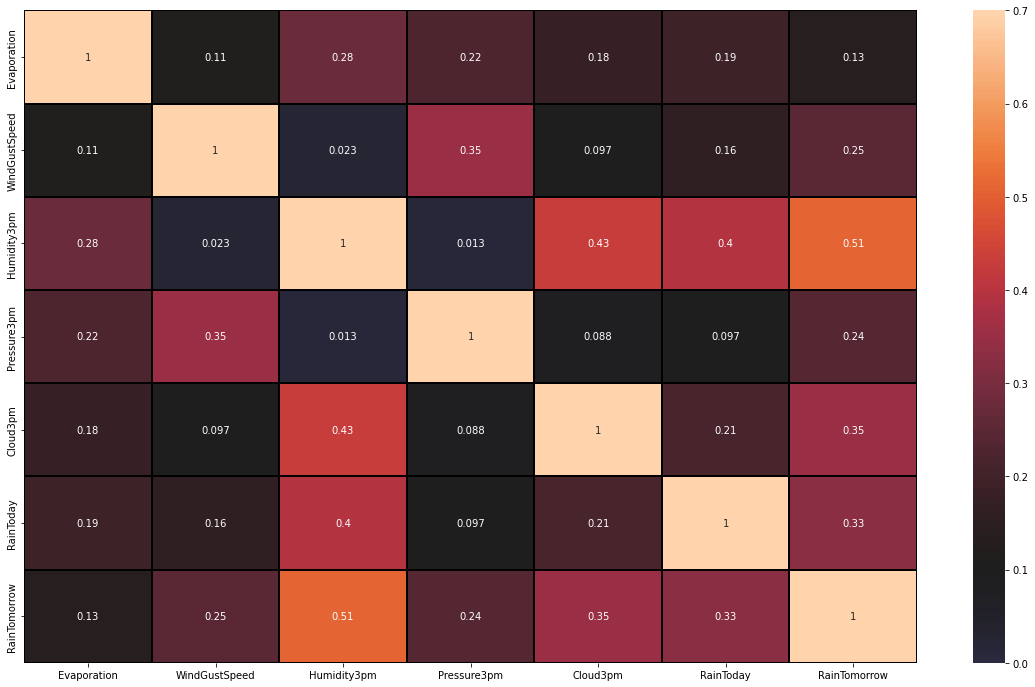

In [1079]:
plt.figure(figsize=(20, 12))
sns.heatmap(abs(data_work.corr()), 
            center=0.1, annot=True, 
            linecolor='black', 
            linewidths=0.4, vmin=0, vmax=0.7)
plt.show()

In [1080]:
results

,Описание,ROC_AUC,Accuracy,F-score,Precision,Recall
Базовая модель,"без пропусков, без категорий, MinMax scale",0.889823,0.858602,0.628636,0.747453,0.542412
Шаг 1,"Пропуски mean, категории Labelencoding, выброс...",0.866978,0.787599,0.741932,0.773345,0.712972
Шаг 2,"То же что и шаг1, но дропнуты колонки",0.854438,0.776163,0.728630,0.757685,0.701722


Выводы из проделанной работы:

1. Получил базовую модель. Модель показывала высокую метрику ROC_AUC при низком F-score. То есть возможность улучшения модели сильно ограничена. 
2. Обработал данные: Заменил пропуски (на mean), сбалансировал целевой признак через oversampling, подрезал выбросы. Получил модель с 17% приростом Recall относительно базового варианта без существенной просадки метрик
3. Рассмотрел тепловую карту взаимных корреляций, убрав несущественные признаки удалось при просадке F-score на 1,6% добиться сокращения количества признаков с 22 до 7.

Таким образом, получил опыт обработки данных. Убедился на цифрах в эффективности предобработки данных.